In [65]:
import os  # when loading file paths
import pandas as pd  # for lookup in annotation file
import spacy  # for tokenizer
import torch
from torch.nn.utils.rnn import pad_sequence  # pad batch
from torch.utils.data import DataLoader, Dataset
from PIL import Image  # Load img
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import statistics
import torchvision.models as models
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
# Setting device on GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

torch.backends.cudnn.deterministic = True

Using device: cuda

Tesla K80
Memory Usage:
Allocated: 0.4 GB
Cached:    3.2 GB


/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:386: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


#### Loading Datas

In [67]:
spacy_eng = spacy.load("en")

In [68]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

In [69]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
        self.root_dir = root_dir

        self.df = pd.read_csv(captions_file, error_bad_lines=False, names=['image', 'caption'], header=None, sep='\t', nrows=200)
        self.transform = transform
        print(len(self.df))
        # Get img, caption columns
        self.df["image"] = self.df["image"].apply(lambda x: self.removeNumbers(x))
        self.imgs = self.df["image"]

        self.captions = self.df["caption"]

        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())

    def removeNumbers(self, image):
          image = image.split('#')[0]
          check = image.split('.')
          if len(check)>2:
            image = check[0]+"."+check[1]
          return image

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(numericalized_caption)

In [70]:
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        return imgs, targets

In [71]:
def get_loader(
    root_folder,annotation_file,transform,batch_size=32,
    num_workers=8,shuffle=True,pin_memory=True,):
  
    dataset = FlickrDataset(root_folder, annotation_file, transform=transform)

    pad_idx = dataset.vocab.stoi["<PAD>"]

    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx=pad_idx),
    )

    return loader, dataset

#### implementing Networks

In [72]:
class BahdanauAttention(nn.Module):

    def __init__(self, num_features, hidden_dim, output_dim = 1):
        super(BahdanauAttention, self).__init__()
        self.num_features = num_features
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.W_a = nn.Linear(self.num_features, self.hidden_dim)
        self.U_a = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.v_a = nn.Linear(self.hidden_dim, self.output_dim)
                
    def forward(self, features, decoder_hidden):
        decoder_hidden = decoder_hidden.unsqueeze(1)
        atten_1 = self.W_a(features)
        atten_2 = self.U_a(decoder_hidden)
        atten_tan = torch.tanh(atten_1+atten_2)
        atten_score = self.v_a(atten_tan)
        atten_weight = F.softmax(atten_score, dim = 1)
        context = torch.sum(atten_weight * features,  dim = 1)
        atten_weight = atten_weight.squeeze(dim=2)
        
        return context, atten_weight


class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        
    def forward(self, images):
        features = self.resnet(images)
        batch, feature_maps, size_1, size_2 = features.size()       
        features = features.permute(0, 2, 3, 1)
        features = features.view(batch, size_1*size_2, feature_maps)
        
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, num_features):
        super(DecoderRNN, self).__init__()
        self.num_features = num_features
        self.embedding_dim = embed_size
        self.hidden_dim = hidden_size
        self.vocab_size = vocab_size
        self.sample_temp = 0.5

        self.embeddings = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTMCell(embed_size + num_features, hidden_size)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.attention = BahdanauAttention(num_features, hidden_size)
        self.drop = nn.Dropout(0.5)
        self.init_h = nn.Linear(num_features, hidden_size)
        self.init_c = nn.Linear(num_features, hidden_size)

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, features, captions, sample_prob = 0.0):
        embed = self.embeddings(captions)
        h, c = self.init_hidden(features)
        seq_len = embed.size(1)
        feature_size = features.size(1)
        batch_size = embed.size(0)
        
        outputs = torch.zeros(batch_size, seq_len, self.vocab_size).to(device)
        atten_weights = torch.zeros(batch_size, seq_len, feature_size).to(device)
        word_embed = embed[:,0,:]
        for t in range(seq_len):

            context, atten_weight = self.attention(features, h)
            # input_concat shape at time step t = (batch, embedding_dim + hidden_dim)
            input_concat = torch.cat([word_embed, context], 1)
            h, c = self.lstm(input_concat, (h,c))
            h = self.drop(h)
            output = self.fc(h)
            outputs[:, t, :] = output
            atten_weights[:, t, :] = atten_weight

            scoring = F.log_softmax(output, dim=1)
            top_idx = scoring.topk(1)[1]
            word_embed = self.embeddings(top_idx).squeeze(1)
            # print(top_idx.shape)
            
        return outputs, atten_weights


    def init_hidden(self, features):
        mean_annotations = torch.mean(features, dim = 1)
        h0 = self.init_h(mean_annotations)
        c0 = self.init_c(mean_annotations)
        return h0, c0
    def greedy_search(self, features, vocabulary, max_sentence = 40):

        sentence = []
        weights = []
        input_word = torch.tensor([vocabulary.stoi['<SOS>']]).to(device)
        h, c = self.init_hidden(features)
        while True:
            embedded_word = self.embeddings(input_word)
            context, atten_weight = self.attention(features, h)
            # input_concat shape at time step t = (batch, embedding_dim + context size)
            input_concat = torch.cat([embedded_word, context],  dim = 1)
            h, c = self.lstm(input_concat, (h,c))
            h = self.drop(h)
            output = self.fc(h)
            scoring = F.log_softmax(output, dim=1)
            top_idx = scoring[0].topk(1)[1]
            sentence.append(top_idx.item())
            weights.append(atten_weight)
            input_word = torch.tensor(top_idx)
            if (len(sentence) >= max_sentence or top_idx == vocabulary.stoi['<EOS>']):
                break
        return sentence, weights


class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, num_features):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers, num_features)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs, _ = self.decoderRNN(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length=40):
        result_caption = []

        with torch.no_grad():
            x = self.encoderCNN(image)
            sentence, weights = self.decoderRNN.greedy_search(x, vocabulary, max_sentence = max_length)

        return [vocabulary.itos[idx] for idx in sentence]


    def init_hidden(self, features):
        mean_annotations = torch.mean(features, dim = 1)
        h0 = self.init_h(mean_annotations)
        c0 = self.init_c(mean_annotations)
        return h0, c0



#### Training

In [73]:
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_model = False
save_model = False
train_CNN = False


# Hyperparameters
batch_size = 5
embed_size = 256
hidden_size = 512
num_features = 2048
num_layers = 1
learning_rate = 1e-4
momentum = 0.9
num_epochs = 200



transform = transforms.Compose([ 
    transforms.Resize(256),                          
    transforms.RandomCrop(224),                     
    transforms.RandomHorizontalFlip(),               
    transforms.ToTensor(),                           
    transforms.Normalize((0.485, 0.456, 0.406),      
                         (0.229, 0.224, 0.225))])

train_loader, dataset = get_loader(
    root_folder="/content/drive/My Drive/Courses/DeepLearning/HW03/Q03/Datas/Flicker8k_Dataset",
    annotation_file="/content/drive/My Drive/Courses/DeepLearning/HW03/Q03/Datas/Flickr8k.token.txt",
    transform=transform,
    num_workers=2,
    batch_size=batch_size,
)

vocab_size = len(dataset.vocab)


# initialize model, loss etc
model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers, num_features).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

200


In [74]:
def train(print_every):

    
    for epoch in range(num_epochs):
        model.train()
        # Uncomment the line below to see a couple of test cases
        # print_examples(model, device, dataset)
        step = 0

        for idx, (imgs, captions) in tqdm(
            enumerate(train_loader), total=len(train_loader), leave=False
        ):
            imgs = imgs.to(device)
            captions = captions.to(device)
            captions = captions.permute(1,0)
            
            outputs = model(imgs, captions)

            loss = criterion(outputs.view(-1, vocab_size), captions.reshape(-1))

            stats = '  Loss = %.4f' % (loss.item())
            if step % print_every == 0:
              print('\r' + stats)


            step += 1

            optimizer.zero_grad()
            loss.backward(loss)
            optimizer.step()

        model.eval()
        plt.imshow(imgs[0].cpu().permute(1,2,0))
        plt.show()
        predicted_caption = model.caption_image(imgs[0].unsqueeze(0), dataset.vocab)
        print("\n"+" ".join(predicted_caption))

  2%|▎         | 1/40 [00:00<00:16,  2.43it/s]

  Loss = 4.5930


 52%|█████▎    | 21/40 [00:06<00:07,  2.64it/s]

  Loss = 3.1822


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


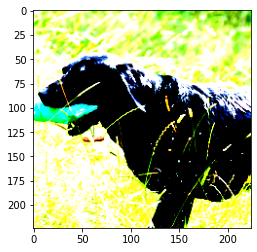


<SOS> a a <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  2%|▎         | 1/40 [00:00<00:26,  1.45it/s]

  Loss = 3.3258


 52%|█████▎    | 21/40 [00:07<00:06,  3.13it/s]

  Loss = 3.1222


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


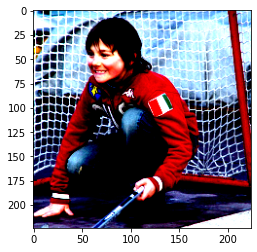


<SOS> a <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


  2%|▎         | 1/40 [00:00<00:25,  1.56it/s]

  Loss = 3.1952


 52%|█████▎    | 21/40 [00:05<00:04,  4.70it/s]

  Loss = 3.3094


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


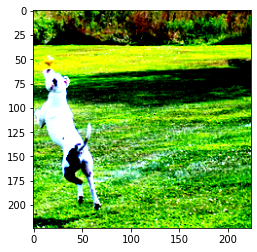


<SOS> a <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <EOS>


  2%|▎         | 1/40 [00:00<00:15,  2.56it/s]

  Loss = 2.9301


 52%|█████▎    | 21/40 [00:04<00:04,  4.70it/s]

  Loss = 2.9268


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


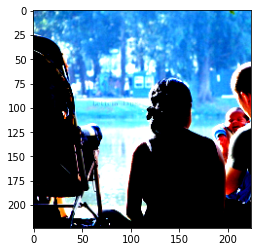


<SOS> a <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


  2%|▎         | 1/40 [00:00<00:13,  2.88it/s]

  Loss = 2.6058


 52%|█████▎    | 21/40 [00:04<00:04,  4.73it/s]

  Loss = 3.0573


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


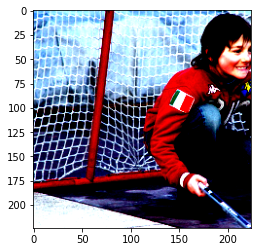


<SOS> a <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


  2%|▎         | 1/40 [00:00<00:14,  2.68it/s]

  Loss = 2.8758


 52%|█████▎    | 21/40 [00:04<00:04,  4.70it/s]

  Loss = 2.7518


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


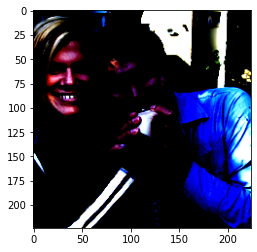


<SOS> a <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <EOS>


  2%|▎         | 1/40 [00:00<00:13,  2.81it/s]

  Loss = 2.9478


 52%|█████▎    | 21/40 [00:04<00:03,  4.94it/s]

  Loss = 2.6109


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


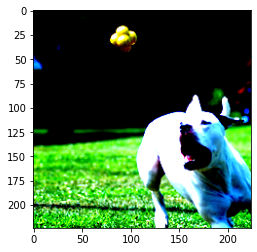


<SOS> a dog dog <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <EOS>


  2%|▎         | 1/40 [00:00<00:14,  2.62it/s]

  Loss = 3.0295


 52%|█████▎    | 21/40 [00:04<00:04,  4.66it/s]

  Loss = 2.7627


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


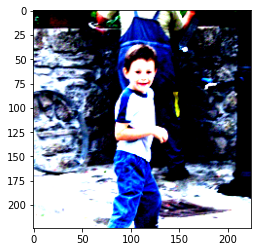


<SOS> a man <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <EOS>


  2%|▎         | 1/40 [00:00<00:30,  1.26it/s]

  Loss = 2.8488


 52%|█████▎    | 21/40 [00:05<00:04,  4.66it/s]

  Loss = 2.6185


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


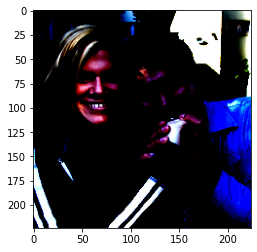


<SOS> a man <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


  2%|▎         | 1/40 [00:00<00:15,  2.58it/s]

  Loss = 2.8459


 52%|█████▎    | 21/40 [00:04<00:03,  4.82it/s]

  Loss = 2.4204


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


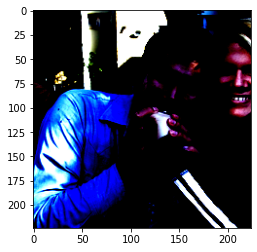


<SOS> a man <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


  2%|▎         | 1/40 [00:00<00:14,  2.77it/s]

  Loss = 2.4098


 52%|█████▎    | 21/40 [00:04<00:04,  4.67it/s]

  Loss = 2.6359


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


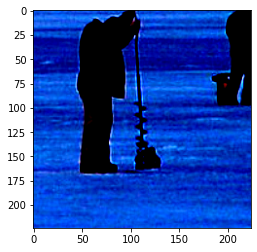


<SOS> a man <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <EOS>


  2%|▎         | 1/40 [00:00<00:14,  2.62it/s]

  Loss = 2.7184


 52%|█████▎    | 21/40 [00:04<00:04,  4.73it/s]

  Loss = 2.5428


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


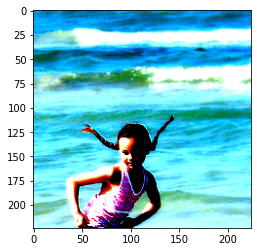


<SOS> a girl <UNK> in in the the the <EOS>


  2%|▎         | 1/40 [00:00<00:31,  1.22it/s]

  Loss = 2.7078


 52%|█████▎    | 21/40 [00:05<00:04,  4.75it/s]

  Loss = 2.5942


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


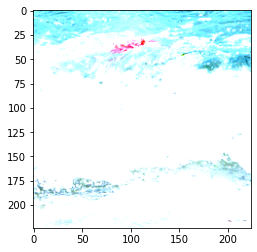


<SOS> a <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <EOS>


  2%|▎         | 1/40 [00:00<00:15,  2.49it/s]

  Loss = 2.4067


 52%|█████▎    | 21/40 [00:04<00:03,  4.82it/s]

  Loss = 2.2339


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


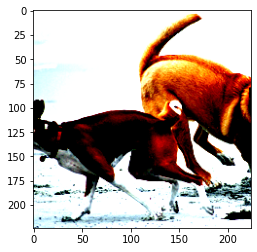


<SOS> a man <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <EOS>


  2%|▎         | 1/40 [00:00<00:15,  2.58it/s]

  Loss = 2.5445


 52%|█████▎    | 21/40 [00:04<00:03,  4.76it/s]

  Loss = 2.3171


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


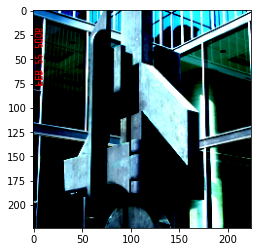


<SOS> a man man <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <EOS>


  2%|▎         | 1/40 [00:00<00:15,  2.56it/s]

  Loss = 2.4981


 52%|█████▎    | 21/40 [00:04<00:04,  4.70it/s]

  Loss = 2.2067


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


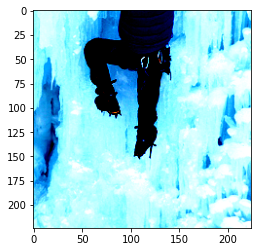


<SOS> a <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <EOS>


  2%|▎         | 1/40 [00:00<00:14,  2.64it/s]

  Loss = 2.4377


 52%|█████▎    | 21/40 [00:04<00:03,  4.76it/s]

  Loss = 2.7747


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


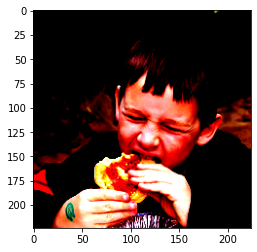


<SOS> a boy <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <EOS>


  2%|▎         | 1/40 [00:00<00:14,  2.65it/s]

  Loss = 2.4695


 52%|█████▎    | 21/40 [00:04<00:04,  4.70it/s]

  Loss = 2.4314


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


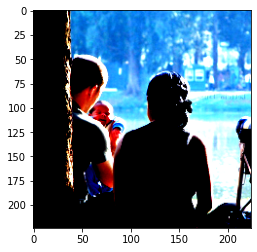


<SOS> a man <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <EOS>


  2%|▎         | 1/40 [00:00<00:14,  2.70it/s]

  Loss = 2.4183


 52%|█████▎    | 21/40 [00:04<00:04,  4.63it/s]

  Loss = 2.5174


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


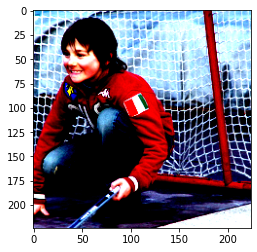


<SOS> a <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


  2%|▎         | 1/40 [00:00<00:15,  2.58it/s]

  Loss = 2.6174


 52%|█████▎    | 21/40 [00:04<00:04,  4.75it/s]

  Loss = 2.2368


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


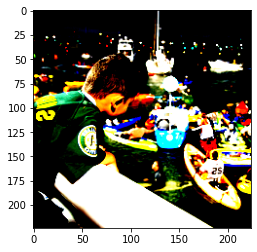


<SOS> a boy boy a <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


  2%|▎         | 1/40 [00:00<00:14,  2.76it/s]

  Loss = 2.2257


 52%|█████▎    | 21/40 [00:04<00:04,  4.62it/s]

  Loss = 2.3345


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


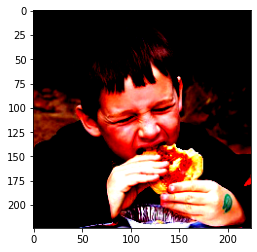


<SOS> a boy <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <EOS>


  2%|▎         | 1/40 [00:00<00:14,  2.66it/s]

  Loss = 2.2642


 52%|█████▎    | 21/40 [00:04<00:03,  4.79it/s]

  Loss = 2.1274


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


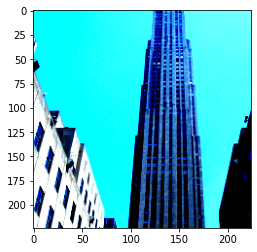


<SOS> a a a <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


  2%|▎         | 1/40 [00:00<00:14,  2.69it/s]

  Loss = 2.4568


 52%|█████▎    | 21/40 [00:04<00:04,  4.66it/s]

  Loss = 2.4554


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


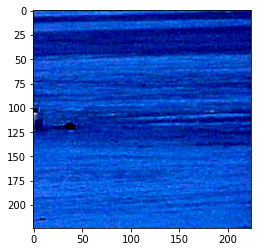


<SOS> two <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <EOS>


  2%|▎         | 1/40 [00:00<00:14,  2.71it/s]

  Loss = 2.7514


 52%|█████▎    | 21/40 [00:04<00:04,  4.69it/s]

  Loss = 2.3265


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


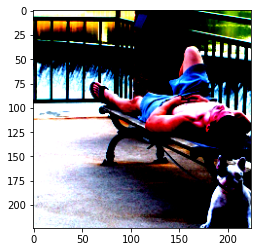


<SOS> a man <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <EOS>


  2%|▎         | 1/40 [00:00<00:13,  2.79it/s]

  Loss = 2.4931


 52%|█████▎    | 21/40 [00:04<00:04,  4.75it/s]

  Loss = 2.5722


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


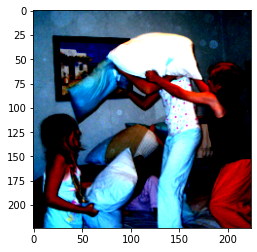


<SOS> a <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <EOS>


  2%|▎         | 1/40 [00:00<00:15,  2.48it/s]

  Loss = 2.4961


 52%|█████▎    | 21/40 [00:04<00:03,  4.80it/s]

  Loss = 2.2630


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


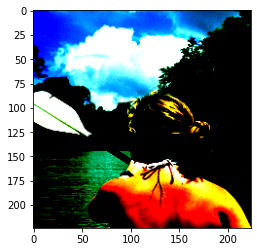


<SOS> a woman <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> . . <EOS>


  2%|▎         | 1/40 [00:00<00:15,  2.46it/s]

  Loss = 2.4119


 52%|█████▎    | 21/40 [00:04<00:04,  4.69it/s]

  Loss = 2.2035


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


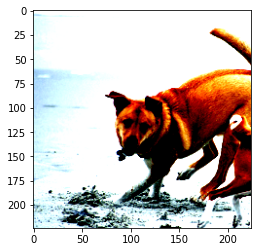


<SOS> two dogs <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> . <EOS>


  2%|▎         | 1/40 [00:00<00:25,  1.53it/s]

  Loss = 2.2379


 52%|█████▎    | 21/40 [00:04<00:04,  4.69it/s]

  Loss = 2.4533


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


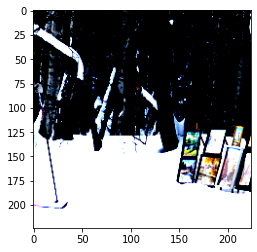


<SOS> a man <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <EOS>


  2%|▎         | 1/40 [00:00<00:14,  2.61it/s]

  Loss = 2.3911


 52%|█████▎    | 21/40 [00:04<00:04,  4.70it/s]

  Loss = 2.1086


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


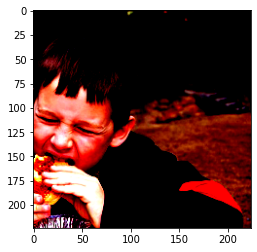


<SOS> a boy <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> . . <EOS>


  2%|▎         | 1/40 [00:00<00:15,  2.46it/s]

  Loss = 2.3218


 52%|█████▎    | 21/40 [00:04<00:04,  4.64it/s]

  Loss = 2.2531


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


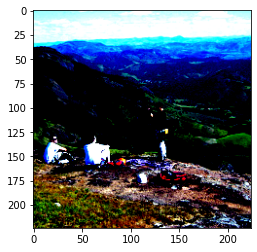


<SOS> three people <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <EOS>


  2%|▎         | 1/40 [00:00<00:15,  2.59it/s]

  Loss = 2.4363


 52%|█████▎    | 21/40 [00:04<00:03,  4.76it/s]

  Loss = 2.3951


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


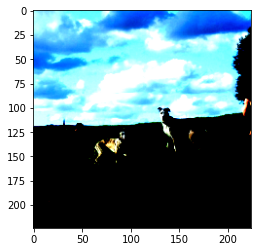


<SOS> three dogs dogs <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <EOS>


  2%|▎         | 1/40 [00:00<00:14,  2.61it/s]

  Loss = 2.2954


 52%|█████▎    | 21/40 [00:04<00:03,  4.77it/s]

  Loss = 2.1518


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


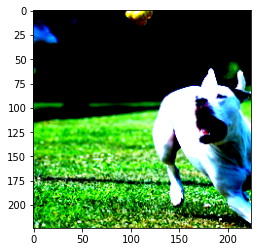


<SOS> a white dog dog <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <EOS>


  2%|▎         | 1/40 [00:00<00:15,  2.56it/s]

  Loss = 2.2298


 52%|█████▎    | 21/40 [00:04<00:04,  4.60it/s]

  Loss = 2.2138


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


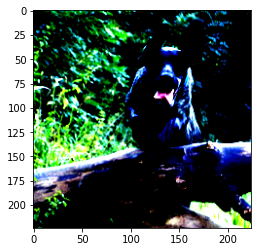


<SOS> a black dog <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> . . . <EOS>


  2%|▎         | 1/40 [00:00<00:14,  2.71it/s]

  Loss = 2.1277


 52%|█████▎    | 21/40 [00:04<00:04,  4.53it/s]

  Loss = 2.3370


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


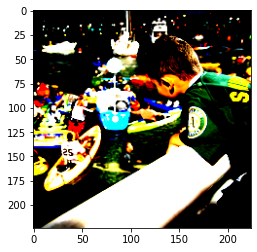


<SOS> a boy boy a a <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <EOS>


  2%|▎         | 1/40 [00:00<00:15,  2.47it/s]

  Loss = 2.0352


 52%|█████▎    | 21/40 [00:04<00:03,  4.82it/s]

  Loss = 1.9741


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


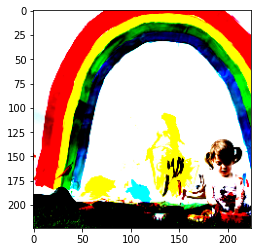


<SOS> a little girl girl in in in in <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <EOS>


  2%|▎         | 1/40 [00:00<00:15,  2.52it/s]

  Loss = 1.9805


 52%|█████▎    | 21/40 [00:04<00:04,  4.54it/s]

  Loss = 2.1631


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


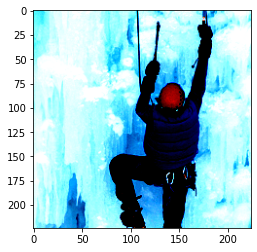


<SOS> a ice ice <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <EOS>


  2%|▎         | 1/40 [00:00<00:15,  2.45it/s]

  Loss = 2.3659


 52%|█████▎    | 21/40 [00:04<00:04,  4.55it/s]

  Loss = 2.1576


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


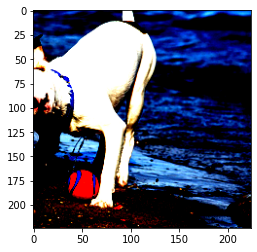


<SOS> a dog <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> . . . . . . . . . . . . . . <EOS>


  2%|▎         | 1/40 [00:00<00:15,  2.58it/s]

  Loss = 2.4389


 52%|█████▎    | 21/40 [00:04<00:04,  4.64it/s]

  Loss = 2.5696


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


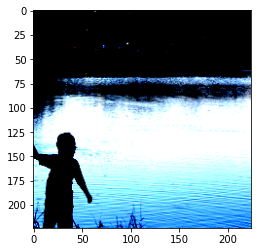


<SOS> a boy <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <EOS>


  2%|▎         | 1/40 [00:00<00:16,  2.39it/s]

  Loss = 2.0559


 52%|█████▎    | 21/40 [00:04<00:04,  4.64it/s]

  Loss = 2.8033


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


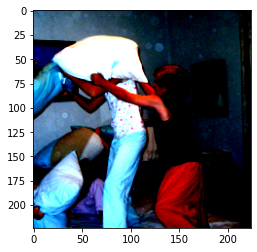


<SOS> a <UNK> <UNK> <UNK> <UNK> pillow fight fight fight fight <EOS>


  2%|▎         | 1/40 [00:00<00:16,  2.41it/s]

  Loss = 2.3131


 52%|█████▎    | 21/40 [00:04<00:04,  4.66it/s]

  Loss = 2.0910


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


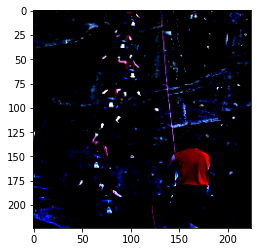


<SOS> a <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <EOS>


  2%|▎         | 1/40 [00:00<00:15,  2.48it/s]

  Loss = 2.1191


 52%|█████▎    | 21/40 [00:04<00:04,  4.64it/s]

  Loss = 2.4191


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


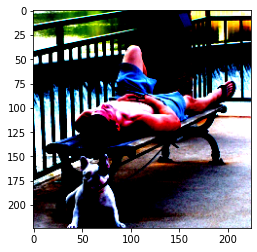


<SOS> a man <UNK> <UNK> <UNK> <UNK> a <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> . <UNK> . <EOS>


  2%|▎         | 1/40 [00:00<00:15,  2.50it/s]

  Loss = 2.3567


 52%|█████▎    | 21/40 [00:04<00:04,  4.53it/s]

  Loss = 2.4099


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


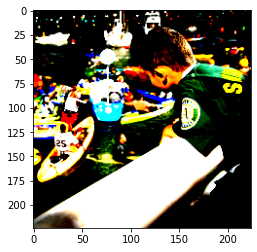


<SOS> a boy boy a boy a <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <EOS>


  2%|▎         | 1/40 [00:00<00:16,  2.42it/s]

  Loss = 1.9190


 40%|████      | 16/40 [00:03<00:05,  4.79it/s]

In [ ]:
train(20)